In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [ ]:
input_size=784
hidden_size=32
num_classes=10

In [ ]:
dataset=MNIST(root='data/',download=True,train=True,transform=ToTensor())

In [ ]:
test_dataset=MNIST(root='data/',train=False,transform=ToTensor())

In [ ]:
train_ds,val_ds=random_split(dataset,[50000,10000])

4


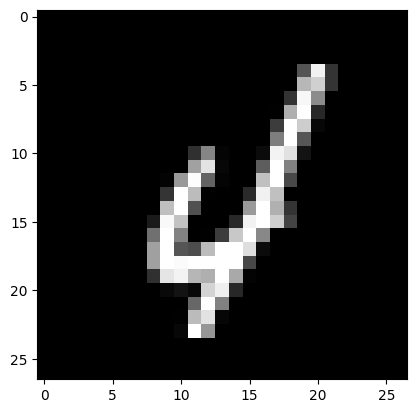

In [ ]:
images,label=train_ds[0]
plt.imshow(images[0,0:27,0:27],cmap='gray')
print(label)

7


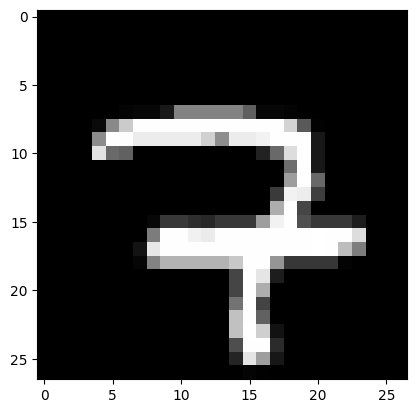

In [ ]:
images,label=val_ds[0]
plt.imshow(images[0,0:27,0:27],cmap='gray')
print(label)

In [ ]:
batch_size=128
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

In [ ]:
def accuracy(out,labels):
  _,preds=torch.max(out,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
class MnistModel(nn.Module):
  def __init__(self,input_size,hidden_size,num_classes):
    super().__init__()
    self.linear1=nn.Linear(input_size,hidden_size)
    self.linear2=nn.Linear(hidden_size,num_classes)
  def forward(self,xb):
    xb=xb.view(xb.size(0),-1)
    out=self.linear1(xb)
    out=F.relu(out)
    out=self.linear2(out)
    return out
  def training_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    return loss
  def validation_step(self,batch):
    images,label=batch
    out=self(images)
    loss=F.cross_entropy(out,label)
    acc=accuracy(out,label)
    return {'val_loss':loss,'val_acc':acc}
  def validation_epoch_end(self,outputs):
    batch_loss=[x['val_loss'] for x in outputs]
    epoch_loss=torch.stack(batch_loss).mean()
    batch_acc=[x['val_acc'] for x in outputs]
    epoch_acc=torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
  def epoch_end(self,epoch,result):
     print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
def evaluate(model,val_loader):
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  history=[]
  optimizer=opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss=model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result=evaluate(model,val_loader)
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [ ]:
model=MnistModel(input_size,hidden_size,num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.31915283203125, 'val_acc': 0.10263671725988388}]

In [ ]:
history=fit(5,0.5,model,train_loader,val_loader)

Epoch [0], val_loss: 0.2426, val_acc: 0.9299
Epoch [1], val_loss: 0.1841, val_acc: 0.9439
Epoch [2], val_loss: 0.1812, val_acc: 0.9474
Epoch [3], val_loss: 0.1446, val_acc: 0.9602
Epoch [4], val_loss: 0.1449, val_acc: 0.9568


Text(0.5, 1.0, 'Loss vs. No. of epochs')

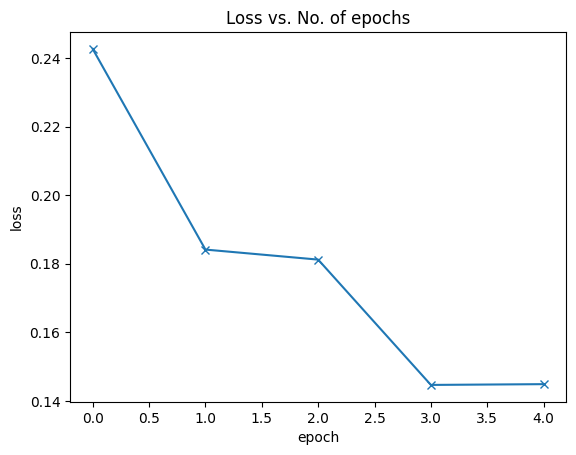

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

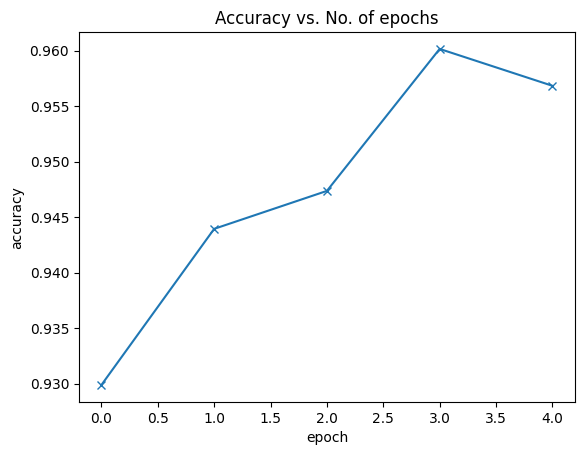

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


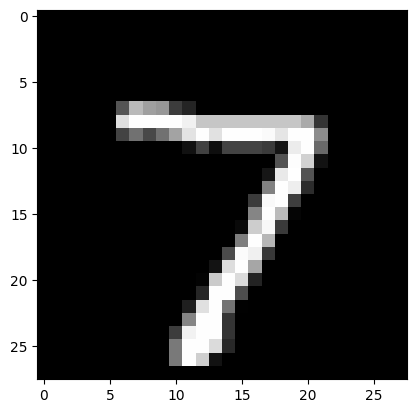

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


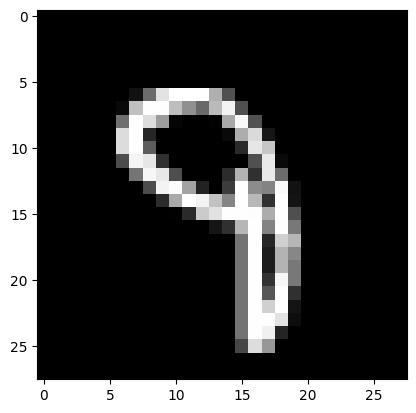

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


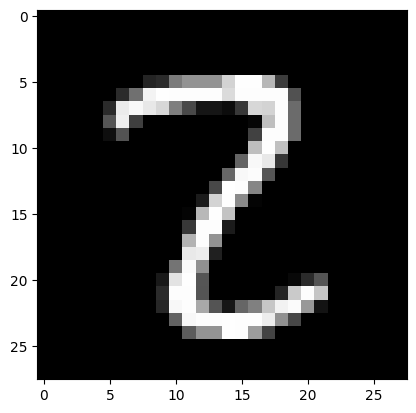

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))